In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.spatial import distance
from sklearn.neighbors import KNeighborsClassifier,LocalOutlierFactor
import h5py as h5
import pywt
import keras
from keras.layers import Conv2D, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.layers import Conv1D, MaxPooling1D, UpSampling1D

Using TensorFlow backend.


In [2]:
# list of time series dataset in databaseXETR.h5
with h5.File("databaseXETR.h5", "r") as f:
    for datasetname in f.keys():
        print(datasetname)

.GDAXI
5ABG.DE
AB1.DE
ADAG.DE
ADSGn.DE
AFXG.DE
AIXGn.DE
ALVG.DE
AQUG.DE
ARLG.DE
B5AG.DE
BAFG.DE
BASFn.DE
BAYGn.DE
BDTG.DE
BEIG.DE
BION.DE
BMWG.DE
BMWG_p.DE
BNRGn.DE
BOSG_p.DE
BVB.DE
BYWGnx.DE
CBKG.DE
CEVG.DE
CLSGn.DE
CONG.DE
CTNG.DE
D9CGn.DE
DAIGn.DE
DAZG.DE
DB1Gn.DE
DBKGn.DE
DEQGn.DE
DEXGn.DE
DEZG.DE
DLGS.DE
DOHG.DE
DPBGn.DE
DPWGn.DE
DRIG.DE
DRWG_p.DE
DTEGn.DE
DUEG.DE
DWNG.DE
EONGn.DE
EVDG.DE
EVTG.DE
FDXc1
FIEG.DE
FMEG.DE
FNTGn.DE
FPEG.DE
FPEG_p.DE
FRAG.DE
FREG.DE
FREG_p.DE
G1AG.DE
GAZPy.DE
GBFG.DE
GFJG.DE
GILG.DE
GMMG.DE
GWIG.DE
GXIG.DE
HDDG.DE
HEIG.DE
HHFGn.DE
HNKG.DE
HNKG_p.DE
HNRGn.DE
HOTG.DE
IFXGn.DE
INHG.DE
IVGG.DE
JUNG_p.DE
KBCG.DE
KCOGn.DE
KD8Gn.DE
KRNG.DE
KU2G.DE
LEOGn.DE
LHAG.DE
LING.DE
LPKG.DE
LXSG.DE
M5ZG.DE
MANG.DE
MANG_p.DE
MEOG.DE
MORG.DE
MRCG.DE
MTXGn.DE
MUVGn.DE
NAFG.DE
NDXG.DE
PFDGn.DE
PRAG.DE
PS4G.DE
PSHG_p.DE
PSMG_p.DE
PUMG.DE
PV.DE
QCEG.DE
QGEN.DE
QSCG.DE
R8RG.DE
RAAG.DE
RHKG.DE
RHMG.DE
RWEG.DE
RWEG_p.DE
S2MG.DE
S92G.DE
SAPG.DE
SAXG.DE
SDFG.DE
SFQN.DE
SGCG.DE
SIEG

# Abnormal subsequence detection: instrument code "ADAG.DE" 

In [4]:
# Selection of instrument code 'ADAG.DE' and creation of dataframe
with h5.File("databaseXETR.h5", "r") as f:
    group = f["ADAG.DE"]
    data = group["TRADE"].value
    
df= pd.DataFrame(data,columns = ["close","datetime","epochDateTime","high","instrumentcode",\
                                 "low","nbtick","open","rowEffDateTimeStr","volume","vwap"])
print(df.shape)

(156567, 11)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  after removing the cwd from sys.path.


In [5]:
df.head()

,close,datetime,epochDateTime,high,instrumentcode,low,nbtick,open,rowEffDateTimeStr,volume,vwap
0,4.55,b'2005-01-03 09:03:00',1104739380,4.55,b'ADAG.DE',4.55,1,4.55,b'',1000,4.55
1,4.52,b'2005-01-03 09:46:00',1104741960,4.52,b'ADAG.DE',4.52,1,4.52,b'',1500,4.52
2,4.59,b'2005-01-03 09:47:00',1104742020,4.59,b'ADAG.DE',4.59,1,4.59,b'',100,4.59
3,4.56,b'2005-01-03 09:52:00',1104742320,4.56,b'ADAG.DE',4.56,1,4.56,b'',1500,4.56
4,4.57,b'2005-01-03 10:52:00',1104745920,4.57,b'ADAG.DE',4.57,1,4.57,b'',1,4.57


In [6]:
# Type convertion 
df["close"] = df["close"].astype("float")
df["epochDateTime"] = df["epochDateTime"].astype("int")
df["high"] = df["high"].astype("float")
df["low"] = df["low"].astype("float")
df["open"] = df["open"].astype("float")
df["vwap"] = df["vwap"].astype("float")
df["nbtick"] = df["nbtick"].astype("int")
df["volume"] = df["volume"].astype("int")
df["datetime"] = df["datetime"].apply(lambda row:row.decode('UTF-8'))
df["datetime"] = pd.to_datetime(df["datetime"])

In [7]:
df2 = df[["datetime","close"]].copy()
df2.index = df2["datetime"]
del df2["datetime"]

In [8]:
df2.head()

,close
datetime,
2005-01-03 09:03:00,4.55
2005-01-03 09:46:00,4.52
2005-01-03 09:47:00,4.59
2005-01-03 09:52:00,4.56
2005-01-03 10:52:00,4.57


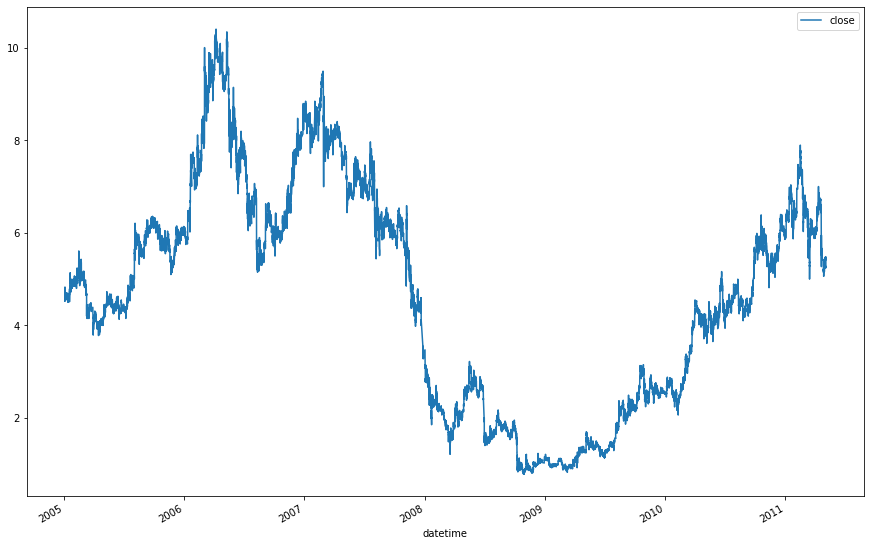

In [12]:
df2.plot(figsize=(15,10))

In [22]:
# creation of subsequences of size 28, the indices correspond to the dates of the middle of the subsequences
dico = {}
for i in range(0,df2.shape[0],28):
    ind = df2.index.values[i+14] 
    dico[ind] = df2.values[i:i+28]
    
newDf = pd.DataFrame.from_dict(dico,orient='index')
newDf.columns = ["rawTs"]
print(newDf.loc[newDf.index == pd.to_datetime('2011-05-03 17:26:00')].values[0][0].shape)
newDf.drop(index =[pd.to_datetime('2011-05-03 17:26:00')],inplace=True)

(19, 1)


In [24]:
newDf.head()

,rawTs
2005-01-03 12:18:00,"[[4.550000190734863], [4.519999980926514], [4...."
2005-01-04 11:20:00,"[[4.829999923706055], [4.75], [4.75], [4.75], ..."
2005-01-05 17:28:00,"[[4.679999828338623], [4.679999828338623], [4...."
2005-01-07 10:47:00,"[[4.599999904632568], [4.599999904632568], [4...."
2005-01-11 15:14:00,"[[4.699999809265137], [4.699999809265137], [4...."


In [23]:
# Creation of a new dataframe df_last from newDf, where each value in the subsequence corresponds to a column
X = np.zeros((newDf.shape[0],29),dtype='O')
for row,i in enumerate(newDf.index):
    X[row,0]= i
    for c in range(28):
        X[row,c+1]= newDf.loc[newDf.index == i].values[0][0][c][0]
        
df_last = pd.DataFrame(X)
df_last.columns = ["Time"] + ["ts{}".format(i+1) for i in range(28)]
df_last["Time"] = pd.to_datetime(df_last["Time"])
L = ["ts{}".format(i+1) for i in range(28)]
for c in L:
    df_last[c]=df_last[c].astype("float")
    
df_last.index = df_last["Time"]
del df_last["Time"]

In [25]:
df_last.head()

,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,...,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28
Time,,,,,,,,,,,,,,,,,,,,,
2005-01-03 12:18:00,4.55,4.52,4.59,4.56,4.57,4.57,4.52,4.52,4.57,4.60,...,4.68,4.70,4.70,4.70,4.70,4.73,4.75,4.75,4.78,4.80
2005-01-04 11:20:00,4.83,4.75,4.75,4.75,4.75,4.80,4.69,4.69,4.76,4.75,...,4.58,4.61,4.57,4.60,4.65,4.65,4.65,4.67,4.69,4.69
2005-01-05 17:28:00,4.68,4.68,4.62,4.66,4.68,4.67,4.68,4.68,4.70,4.66,...,4.65,4.65,4.65,4.65,4.61,4.61,4.60,4.60,4.60,4.60
2005-01-07 10:47:00,4.60,4.60,4.64,4.58,4.57,4.55,4.65,4.60,4.65,4.65,...,4.64,4.65,4.68,4.64,4.69,4.69,4.65,4.65,4.65,4.69
2005-01-11 15:14:00,4.70,4.70,4.70,4.70,4.70,4.60,4.68,4.68,4.60,4.68,...,4.55,4.57,4.56,4.57,4.57,4.57,4.57,4.57,4.57,4.56


In [31]:
df_last.shape

(5591, 28)

## Analysis with discrete wavelet transform

In [27]:
# Creation of a new dataframe df_last_dwt of Wavelet coefficients, we apply a DWT transformation to df_last
df_last_dwt = df_last.copy()
for i in range(df_last_dwt.shape[0]):
    cA, cD = pywt.dwt(df_last_dwt.loc[df_last_dwt.index == df_last_dwt.index[i]].values, 'db1')
    C = np.concatenate((cA.T,cD.T),axis=0)
    df_last_dwt.loc[df_last_dwt.index == df_last_dwt.index[i]] = C.T
    
print(df_last_dwt.shape)

(5591, 28)


In [28]:
df_last_dwt.head(3)

,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,...,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28
Time,,,,,,,,,,,,,,,,,,,,,
2005-01-03 12:18:00,6.413459,6.470027,6.462956,6.392245,6.484169,6.505382,6.547809,6.590235,6.632662,6.632661,...,-0.021213,0.000000,-0.098995,0.014142,0.000000,-0.014142,0.000000,-0.021213,0.000000,-0.014142
2005-01-04 11:20:00,6.774083,6.717514,6.752870,6.632662,6.724586,6.604377,6.583164,6.505382,6.491240,6.498311,...,0.007071,-0.042426,0.049498,0.000000,0.014142,-0.021213,-0.021213,0.000000,-0.014142,0.000000
2005-01-05 17:28:00,6.618519,6.561951,6.611448,6.618519,6.618519,6.618519,6.639733,6.561951,6.618519,6.576093,...,0.028284,-0.028284,-0.007071,-0.028284,-0.028284,0.000000,0.000000,0.000000,0.000000,0.000000


In [29]:
df_last.head(3)

,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,...,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28
Time,,,,,,,,,,,,,,,,,,,,,
2005-01-03 12:18:00,4.55,4.52,4.59,4.56,4.57,4.57,4.52,4.52,4.57,4.60,...,4.68,4.70,4.70,4.70,4.70,4.73,4.75,4.75,4.78,4.80
2005-01-04 11:20:00,4.83,4.75,4.75,4.75,4.75,4.80,4.69,4.69,4.76,4.75,...,4.58,4.61,4.57,4.60,4.65,4.65,4.65,4.67,4.69,4.69
2005-01-05 17:28:00,4.68,4.68,4.62,4.66,4.68,4.67,4.68,4.68,4.70,4.66,...,4.65,4.65,4.65,4.65,4.61,4.61,4.60,4.60,4.60,4.60


In [30]:
# Standard scaling of columns
X_std = df_last_dwt.copy()
for c in X_std.columns:
    scaler = StandardScaler()
    scaler.fit(X_std[c].values.reshape(-1, 1))
    X_std[c] = scaler.transform(X_std[c].values.reshape(-1, 1))
    del scaler
    
df_results=df_last.copy()

### Isolation Forest

In [31]:
# Calculation of the outlier score
algoDetector = IsolationForest(n_estimators=700,n_jobs=-1)
algoDetector.fit(X_std)
df_results["score_IF"] = -algoDetector.score_samples(X_std)

In [32]:
# The first 20 most outliers 
df_results.sort_values("score_IF",ascending=False)["score_IF"].head(20)

Time
2006-04-04 13:55:00    0.671265
2006-04-20 15:16:00    0.670718
2006-05-10 09:50:00    0.663179
2006-04-07 17:36:00    0.661310
2006-04-05 16:37:00    0.653686
2006-04-05 15:05:00    0.652562
2006-05-12 11:46:00    0.649383
2006-05-15 09:44:00    0.646201
2006-05-09 11:28:00    0.645925
2006-04-06 17:07:00    0.642713
2006-04-19 17:17:00    0.640445
2006-03-17 09:32:00    0.640288
2006-03-24 12:03:00    0.639143
2006-03-21 12:59:00    0.637646
2006-04-07 11:42:00    0.637174
2006-04-19 15:18:00    0.636006
2006-03-03 16:29:00    0.635813
2006-03-17 16:53:00    0.635153
2006-04-04 16:38:00    0.634589
2006-05-09 09:14:00    0.634568
Name: score_IF, dtype: float64

### Deep auto encoder

In [33]:
X_train, X_val = train_test_split(X_std, test_size=0.10)
print(X_train.shape)
print(X_val.shape)

(5031, 28)
(560, 28)


In [34]:
input_data = Input(shape=(28,))
encoded = Dense(25, activation='relu')(input_data)
encoded = Dense(20, activation='relu')(encoded)
encoded = Dense(15, activation='relu')(encoded)
encoded = Dense(10, activation='relu')(encoded)

decoded = Dense(15, activation='relu')(encoded)
decoded = Dense(20, activation='relu')(decoded)
decoded = Dense(25, activation='relu')(decoded)
decoded = Dense(28, activation=None)(decoded)
autoencoder = Model(input_data, decoded)
encoder = Model(input_data, encoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

callback_AE = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=60,verbose=1),\
                    keras.callbacks.ModelCheckpoint(filepath='TS_AE.h5',monitor='val_loss',save_best_only=True,\
                                                  save_weights_only=True,mode='min',verbose=1)]

In [35]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                725       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                520       
_________________________________________________________________
dense_3 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_5 (Dense)              (None, 15)                165       
_________________________________________________________________
dense_6 (Dense)              (None, 20)                320 

In [36]:
history = autoencoder.fit(X_train, X_train,
                epochs=70,
                batch_size=256,
                shuffle=True,
                validation_data=(X_val, X_val),
                callbacks=callback_AE)

Train on 5031 samples, validate on 560 samples
Epoch 1/70
5031/5031 [==============================] - 0s 66us/step - loss: 0.9914 - val_loss: 1.0315

Epoch 00001: val_loss improved from inf to 1.03150, saving model to TS_AE.h5
Epoch 2/70
5031/5031 [==============================] - 0s 12us/step - loss: 0.9419 - val_loss: 0.9247

Epoch 00002: val_loss improved from 1.03150 to 0.92471, saving model to TS_AE.h5
Epoch 3/70
5031/5031 [==============================] - 0s 11us/step - loss: 0.7681 - val_loss: 0.6580

Epoch 00003: val_loss improved from 0.92471 to 0.65797, saving model to TS_AE.h5
Epoch 4/70
5031/5031 [==============================] - 0s 11us/step - loss: 0.5631 - val_loss: 0.5297

Epoch 00004: val_loss improved from 0.65797 to 0.52973, saving model to TS_AE.h5
Epoch 5/70
5031/5031 [==============================] - 0s 11us/step - loss: 0.5025 - val_loss: 0.5040

Epoch 00005: val_loss improved from 0.52973 to 0.50398, saving model to TS_AE.h5
Epoch 6/70
5031/5031 [==========

5031/5031 [==============================] - 0s 9us/step - loss: 0.3462 - val_loss: 0.3583

Epoch 00046: val_loss improved from 0.35946 to 0.35834, saving model to TS_AE.h5
Epoch 47/70
5031/5031 [==============================] - 0s 9us/step - loss: 0.3450 - val_loss: 0.3571

Epoch 00047: val_loss improved from 0.35834 to 0.35707, saving model to TS_AE.h5
Epoch 48/70
5031/5031 [==============================] - 0s 9us/step - loss: 0.3442 - val_loss: 0.3564

Epoch 00048: val_loss improved from 0.35707 to 0.35637, saving model to TS_AE.h5
Epoch 49/70
5031/5031 [==============================] - 0s 9us/step - loss: 0.3428 - val_loss: 0.3554

Epoch 00049: val_loss improved from 0.35637 to 0.35537, saving model to TS_AE.h5
Epoch 50/70
5031/5031 [==============================] - 0s 9us/step - loss: 0.3421 - val_loss: 0.3535

Epoch 00050: val_loss improved from 0.35537 to 0.35351, saving model to TS_AE.h5
Epoch 51/70
5031/5031 [==============================] - 0s 9us/step - loss: 0.3387 - v

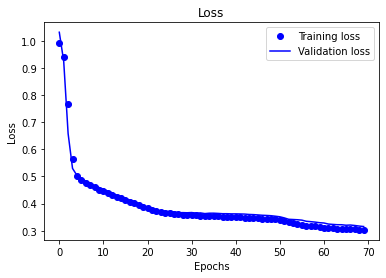

In [37]:
history_dict=history.history
training_loss = history_dict['loss'][0:70:1]
validation_loss = history_dict['val_loss'][0:70:1]
epochs = range(0, 70,1)
plt.plot(epochs, training_loss, 'bo', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
# Calculation of the outlier score
X_recons = autoencoder.predict(X_std)
Error =X_std- X_recons
df_results["score_AE"] = ((Error)**2).sum(axis=1)

In [39]:
# The first 20 most outliers
df_results.sort_values("score_AE",ascending=False)["score_AE"].head(20)

Time
2007-02-28 09:14:00    912.417473
2007-12-27 09:16:00    477.014913
2006-03-03 16:29:00    286.590690
2007-03-14 09:12:00    257.164768
2007-08-01 17:22:00    239.492210
2008-06-30 09:10:00    208.635493
2006-06-14 16:51:00    178.585825
2006-05-15 09:44:00    160.571450
2006-05-18 09:49:00    148.214494
2006-03-10 16:41:00    145.947247
2007-01-19 09:02:00    135.654332
2006-06-09 09:12:00    130.500483
2006-05-23 09:19:00    128.012599
2006-07-17 11:02:00    119.765123
2006-07-31 17:06:00    114.191267
2006-06-02 12:17:00    111.931204
2006-03-07 16:51:00    109.621519
2006-05-31 09:04:00    102.282832
2006-08-03 12:05:00     98.057841
2005-08-12 17:30:00     94.869305
Name: score_AE, dtype: float64

### KNN detector

In [40]:
# Calculation of the outlier score
def knnDetector(df,k=50):
    X = df.copy()
    Y = X.index
    knn = KNeighborsClassifier(n_neighbors=k,n_jobs=-1)
    knn.fit(X_std, Y)
    distances, _ = knn.kneighbors()
    X["knn_score"] = 0.0
    for i in range(X.shape[0]):
        X.loc[X.index[i],"knn_score"] = distances[i].mean()

    return X["knn_score"]

df_results["knn_score"]=knnDetector(X_std,k=100)

In [42]:
# The first 20 most outliers
df_results.sort_values("knn_score",ascending=False)["knn_score"].head(20)

Time
2007-02-28 09:14:00    47.537036
2007-12-27 09:16:00    24.390216
2006-03-03 16:29:00    21.807711
2007-03-14 09:12:00    21.411272
2008-06-30 09:10:00    19.223311
2007-08-01 17:22:00    17.134287
2006-06-09 09:12:00    16.511881
2006-05-23 09:19:00    15.834616
2006-07-17 11:02:00    15.403094
2006-05-15 09:44:00    14.084190
2006-05-30 09:54:00    13.835825
2006-01-18 17:09:00    13.070709
2006-05-10 09:50:00    12.738535
2006-04-20 15:16:00    12.728126
2006-07-31 17:06:00    12.646792
2006-05-18 09:49:00    11.954767
2006-06-14 16:51:00    11.657315
2006-03-03 17:10:00    11.587043
2006-05-29 16:55:00    11.493437
2006-05-12 11:46:00    11.476622
Name: knn_score, dtype: float64

### Local outlier factor (LOF)

In [43]:
# Calculation of the outlier score
LOF = LocalOutlierFactor(n_neighbors=100)
LOF.fit(X_std)
df_results["LOF_score"] = - LOF.negative_outlier_factor_

In [44]:
# The first 20 most outliers
df_results.sort_values("LOF_score",ascending=False)["LOF_score"].head(20)

Time
2007-02-28 09:14:00    9.970785
2007-12-27 09:16:00    6.390137
2008-06-30 09:10:00    5.470712
2007-03-14 09:12:00    4.830231
2006-03-03 16:29:00    4.584368
2007-08-01 17:22:00    4.207022
2006-06-09 09:12:00    4.134316
2006-05-23 09:19:00    4.116452
2006-07-17 11:02:00    3.960488
2008-01-24 09:23:00    3.756880
2008-01-23 09:07:00    3.635231
2006-01-18 17:09:00    3.523169
2010-05-10 09:22:00    3.443550
2006-05-15 09:44:00    3.405792
2006-05-30 09:54:00    3.260516
2005-04-15 14:17:00    3.237997
2005-02-02 15:04:00    3.214858
2006-07-31 17:06:00    3.179706
2006-05-10 09:50:00    3.119960
2006-03-03 17:10:00    3.113140
Name: LOF_score, dtype: float64

## Analysis with convolutional auto-encoder (without DWT)

### 1D convolutional auto-encoder

In [45]:
X_train, X_val = train_test_split(df_last, test_size=0.10)
X_train=X_train.values.reshape(X_train.shape[0],X_train.shape[1],1)
X_val=X_val.values.reshape(X_val.shape[0],X_val.shape[1],1)
print(X_train.shape)
print(X_val.shape)

(5031, 28, 1)
(560, 28, 1)


In [46]:
input_data1D = Input((28,1))
encoded1D = Conv1D(32, 3, activation='relu')(input_data1D)
encoded1D = MaxPooling1D(2)(encoded1D)
encoded1D = Conv1D(64, 3, activation='relu')(encoded1D)
encoded1D = MaxPooling1D(2)(encoded1D)
encoded1D = Conv1D(64, 3, activation='relu')(encoded1D)
encoded1D = Flatten()(encoded1D)
encoded1D = Dense(49, activation='relu')(encoded1D)
decoded1D = Reshape((7,7))(encoded1D)

decoded1D = Conv1D(64,3, activation='relu', padding='same')(decoded1D)
decoded1D = UpSampling1D(2)(decoded1D)
decoded1D = Conv1D(64,3, activation='relu', padding='same')(decoded1D)
decoded1D = UpSampling1D(2)(decoded1D)
decoded1D = Conv1D(32,3, activation='relu', padding='same')(decoded1D)
decoded1D = Conv1D(1,3, activation=None, padding='same')(decoded1D)
autoencoder1D = Model(input_data1D, decoded1D)
autoencoder1D.compile(optimizer='adam', loss='mean_squared_error')

callback_Conv1DAE = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=60,verbose=1),\
                    keras.callbacks.ModelCheckpoint(filepath='Conv_1DAE_DIOR.h5',monitor='val_loss',save_best_only=True,\
                                                  save_weights_only=True,mode='min',verbose=1)]


In [47]:
autoencoder1D.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 32)            128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 11, 64)            6208      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 64)             12352     
_________________________________________________________________
flatten_1 (Flatten)          (None, 192)               0   

In [48]:
history1D = autoencoder1D.fit(X_train, X_train,
                epochs=70,
                batch_size=256,
                shuffle=True,
                validation_data=(X_val, X_val),
                callbacks=callback_Conv1DAE)

Train on 5031 samples, validate on 560 samples
Epoch 1/70
5031/5031 [==============================] - 1s 222us/step - loss: 15.5584 - val_loss: 0.9849

Epoch 00001: val_loss improved from inf to 0.98486, saving model to Conv_1DAE_DIOR.h5
Epoch 2/70
5031/5031 [==============================] - 1s 131us/step - loss: 1.1174 - val_loss: 0.5288

Epoch 00002: val_loss improved from 0.98486 to 0.52878, saving model to Conv_1DAE_DIOR.h5
Epoch 3/70
5031/5031 [==============================] - 1s 134us/step - loss: 0.2374 - val_loss: 0.0774

Epoch 00003: val_loss improved from 0.52878 to 0.07742, saving model to Conv_1DAE_DIOR.h5
Epoch 4/70
5031/5031 [==============================] - 1s 134us/step - loss: 0.0575 - val_loss: 0.0335

Epoch 00004: val_loss improved from 0.07742 to 0.03347, saving model to Conv_1DAE_DIOR.h5
Epoch 5/70
5031/5031 [==============================] - 1s 142us/step - loss: 0.0254 - val_loss: 0.0190

Epoch 00005: val_loss improved from 0.03347 to 0.01904, saving model to


Epoch 00045: val_loss did not improve from 0.00211
Epoch 46/70
5031/5031 [==============================] - 1s 141us/step - loss: 0.0019 - val_loss: 0.0021

Epoch 00046: val_loss improved from 0.00211 to 0.00210, saving model to Conv_1DAE_DIOR.h5
Epoch 47/70
5031/5031 [==============================] - 1s 140us/step - loss: 0.0019 - val_loss: 0.0021

Epoch 00047: val_loss did not improve from 0.00210
Epoch 48/70
5031/5031 [==============================] - 1s 141us/step - loss: 0.0019 - val_loss: 0.0021

Epoch 00048: val_loss did not improve from 0.00210
Epoch 49/70
5031/5031 [==============================] - 1s 147us/step - loss: 0.0019 - val_loss: 0.0021

Epoch 00049: val_loss improved from 0.00210 to 0.00209, saving model to Conv_1DAE_DIOR.h5
Epoch 50/70
5031/5031 [==============================] - 1s 141us/step - loss: 0.0019 - val_loss: 0.0021

Epoch 00050: val_loss did not improve from 0.00209
Epoch 51/70
5031/5031 [==============================] - 1s 146us/step - loss: 0.0019

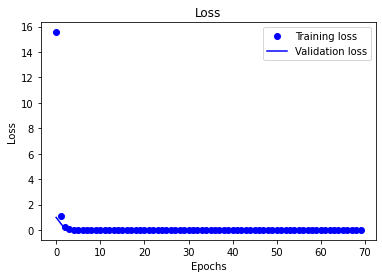

In [49]:
history_dict=history1D.history
training_loss = history_dict['loss'][0:70:1]
validation_loss = history_dict['val_loss'][0:70:1]
epochs = range(0, 70,1)
plt.plot(epochs, training_loss, 'bo', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
#calculation of the outlier score
X_recons_conv1D = autoencoder1D.predict(df_last.values.reshape(df_last.shape[0],df_last.shape[1],1))
X_recons_conv1D=X_recons_conv1D.reshape(X_recons_conv1D.shape[0],X_recons_conv1D.shape[1])
Error1D =df_last- X_recons_conv1D
df_results["score_AE_conv1D"] = ((Error1D)**2).sum(axis=1)

In [51]:
# The first 20 most outliers
df_results.sort_values("score_AE_conv1D",ascending=False)["score_AE_conv1D"].head(20)

Time
2007-02-28 09:14:00    7.615443
2006-03-03 16:29:00    5.388537
2011-04-20 09:12:00    4.854051
2007-11-05 17:18:00    2.827387
2006-05-09 09:14:00    2.258602
2011-02-24 09:09:00    2.013404
2008-06-30 09:10:00    1.788290
2011-03-15 17:23:00    1.702932
2006-05-15 09:44:00    1.560178
2007-12-27 09:16:00    1.530232
2007-08-01 17:22:00    1.513584
2007-03-14 09:12:00    1.420088
2007-08-06 17:22:00    1.287589
2006-01-31 09:02:00    1.239488
2007-07-20 09:10:00    1.236266
2006-05-23 09:19:00    1.159294
2006-05-26 09:04:00    1.134553
2007-02-12 09:14:00    1.123253
2006-06-09 17:20:00    1.099102
2006-01-18 17:09:00    1.061232
Name: score_AE_conv1D, dtype: float64

### 2D convolutional auto-encoder

In [52]:
# Transformation of each subsequence into a two-dimensional matrix
def matrix_transformation(df):
    X=df.copy()
    X_np = np.zeros((X.shape[0],X.shape[1],X.shape[1]))
    for i in range(X.shape[0]):
        for col in range(X.shape[1]):
            cols_list = []
            for j in range(X.shape[1]):
                colN = col+1+j
                if colN >28:
                    colN=colN%28
                
                cols_list.append("ts{}".format(colN))
            
            X_np[i,col,:] = df.loc[df.index[i]][cols_list].values
        
    return X_np

df_img = matrix_transformation(df_last)
X_train, X_val = train_test_split(df_img, test_size=0.10)
X_train=X_train.reshape(X_train.shape[0],28,28,1)
X_val=X_val.reshape(X_val.shape[0],28,28,1)
print(X_train.shape)
print(X_val.shape)

(5031, 28, 28, 1)
(560, 28, 28, 1)


In [53]:
input_data2D = Input((28, 28,1))
encoded2D = Conv2D(32, (3, 3), activation='relu')(input_data2D)
encoded2D = MaxPooling2D((2, 2))(encoded2D)
encoded2D = Conv2D(64, (3, 3), activation='relu')(encoded2D)
encoded2D = MaxPooling2D((2, 2))(encoded2D)
encoded2D = Conv2D(64, (3, 3), activation='relu')(encoded2D)
encoded2D = Flatten()(encoded2D)
encoded2D = Dense(49, activation='relu')(encoded2D)
decoded2D = Reshape((7,7,1))(encoded2D)
decoded2D = Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same')(decoded2D)
decoded2D = Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same')(decoded2D)
decoded2D = Conv2DTranspose(32,(3, 3), activation='relu', padding='same')(decoded2D)
decoded2D = Conv2D(1, (3, 3), activation=None, padding='same')(decoded2D)

autoencoder2D = Model(input_data2D, decoded2D)
autoencoder2D.compile(optimizer='adam', loss='mean_squared_error')

callback_ConvAE2D = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=60,verbose=1),\
                    keras.callbacks.ModelCheckpoint(filepath='Conv_AE_DIOR.h5',monitor='val_loss',save_best_only=True,\
                                                  save_weights_only=True,mode='min',verbose=1)]


In [57]:
autoencoder2D.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0   

In [54]:
history2D = autoencoder2D.fit(X_train, X_train,
                epochs=140,
                batch_size=256,
                shuffle=True,
                validation_data=(X_val, X_val),
                callbacks=callback_ConvAE2D)

Train on 5031 samples, validate on 560 samples
Epoch 1/140
5031/5031 [==============================] - 17s 3ms/step - loss: 17.6597 - val_loss: 6.3563

Epoch 00001: val_loss improved from inf to 6.35629, saving model to Conv_AE_DIOR.h5
Epoch 2/140
5031/5031 [==============================] - 18s 4ms/step - loss: 4.7139 - val_loss: 3.4551

Epoch 00002: val_loss improved from 6.35629 to 3.45513, saving model to Conv_AE_DIOR.h5
Epoch 3/140
5031/5031 [==============================] - 22s 4ms/step - loss: 2.9197 - val_loss: 2.5109

Epoch 00003: val_loss improved from 3.45513 to 2.51089, saving model to Conv_AE_DIOR.h5
Epoch 4/140
5031/5031 [==============================] - 42s 8ms/step - loss: 2.3591 - val_loss: 2.1191

Epoch 00004: val_loss improved from 2.51089 to 2.11913, saving model to Conv_AE_DIOR.h5
Epoch 5/140
5031/5031 [==============================] - 115s 23ms/step - loss: 2.0178 - val_loss: 1.7910

Epoch 00005: val_loss improved from 2.11913 to 1.79096, saving model to Conv_

5031/5031 [==============================] - 46s 9ms/step - loss: 0.4008 - val_loss: 0.3556

Epoch 00044: val_loss improved from 0.35878 to 0.35563, saving model to Conv_AE_DIOR.h5
Epoch 45/140
5031/5031 [==============================] - 52s 10ms/step - loss: 0.3957 - val_loss: 0.3592

Epoch 00045: val_loss did not improve from 0.35563
Epoch 46/140
5031/5031 [==============================] - 47s 9ms/step - loss: 0.3945 - val_loss: 0.3571

Epoch 00046: val_loss did not improve from 0.35563
Epoch 47/140
5031/5031 [==============================] - 52s 10ms/step - loss: 0.3925 - val_loss: 0.3574

Epoch 00047: val_loss did not improve from 0.35563
Epoch 48/140
5031/5031 [==============================] - 47s 9ms/step - loss: 0.3910 - val_loss: 0.3479

Epoch 00048: val_loss improved from 0.35563 to 0.34789, saving model to Conv_AE_DIOR.h5
Epoch 49/140
5031/5031 [==============================] - 48s 9ms/step - loss: 0.3873 - val_loss: 0.3472

Epoch 00049: val_loss improved from 0.34789 to

5031/5031 [==============================] - 38s 7ms/step - loss: 0.3633 - val_loss: 0.3227

Epoch 00093: val_loss improved from 0.32309 to 0.32273, saving model to Conv_AE_DIOR.h5
Epoch 94/140
5031/5031 [==============================] - 43s 9ms/step - loss: 0.3643 - val_loss: 0.3285

Epoch 00094: val_loss did not improve from 0.32273
Epoch 95/140
5031/5031 [==============================] - 41s 8ms/step - loss: 0.3665 - val_loss: 0.3296

Epoch 00095: val_loss did not improve from 0.32273
Epoch 96/140
5031/5031 [==============================] - 44s 9ms/step - loss: 0.3634 - val_loss: 0.3221

Epoch 00096: val_loss improved from 0.32273 to 0.32210, saving model to Conv_AE_DIOR.h5
Epoch 97/140
5031/5031 [==============================] - 49s 10ms/step - loss: 0.3613 - val_loss: 0.3251

Epoch 00097: val_loss did not improve from 0.32210
Epoch 98/140
5031/5031 [==============================] - 47s 9ms/step - loss: 0.3617 - val_loss: 0.3245

Epoch 00098: val_loss did not improve from 0.32

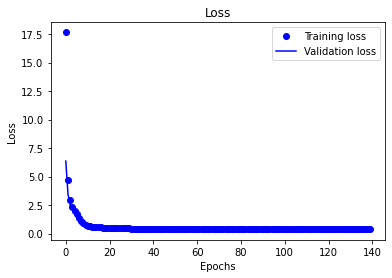

In [55]:
history_dict=history2D.history
training_loss = history_dict['loss'][0:140:1]
validation_loss = history_dict['val_loss'][0:140:1]
epochs = range(0, 140,1)
plt.plot(epochs, training_loss, 'bo', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
#calculation of the outlier score
X_recons_img = autoencoder2D.predict(df_img.reshape(df_img.shape[0],28,28,1))
Error2D =df_img.reshape(df_img.shape[0],28,28,1)- X_recons_img
Error2D=Error2D.reshape(Error2D.shape[0],28,28)
df_results["score_AE_Conv2D"] = ((Error2D)**2).sum(axis=1).sum(axis=1)

In [58]:
# The first 20 most outliers 
df_results.sort_values("score_AE_Conv2D",ascending=False)["score_AE_Conv2D"].head(20)

Time
2006-04-07 14:53:00    1632.681385
2006-04-07 11:42:00    1556.065713
2006-05-10 09:50:00    1544.993993
2006-05-10 13:19:00    1531.900131
2006-05-09 10:09:00    1526.435316
2006-04-07 17:36:00    1517.203195
2006-05-09 15:10:00    1515.201367
2006-05-09 17:01:00    1508.463881
2006-04-04 13:55:00    1503.835901
2006-05-09 13:05:00    1486.413826
2006-04-05 15:05:00    1486.354422
2006-05-09 11:28:00    1485.840686
2006-04-10 14:55:00    1475.027627
2006-04-05 12:40:00    1468.745082
2006-04-04 16:38:00    1462.250453
2006-05-11 15:40:00    1457.268143
2006-04-05 10:55:00    1456.941881
2006-04-04 11:25:00    1451.846499
2006-04-19 17:17:00    1450.806818
2006-05-10 16:19:00    1436.786791
Name: score_AE_Conv2D, dtype: float64

## Final result with ensemble method

In [59]:
df_results.columns[-6:]

Index(['score_IF', 'score_AE', 'knn_score', 'LOF_score', 'score_AE_conv1D',
       'score_AE_Conv2D'],
      dtype='object')

In [60]:
# Normalization of outlier scores
for c in df_results.columns[-6:]:
    scaler = StandardScaler()
    scaler.fit(df_results[c].values.reshape(-1, 1))
    df_results[c] = scaler.transform(df_results[c].values.reshape(-1, 1))
    del scaler

In [62]:
# The final score is equal to the average of all scores
df_results["final_score"]=df_results[df_results.columns[-6:]].mean(axis=1)

In [63]:
# The first 20 most outliers
df_results.sort_values("final_score",ascending=False)["final_score"].head(20)

Time
2007-02-28 09:14:00    22.890973
2006-03-03 16:29:00    11.568061
2007-12-27 09:16:00     9.528322
2007-03-14 09:12:00     6.820203
2008-06-30 09:10:00     6.685166
2007-08-01 17:22:00     5.741193
2006-05-15 09:44:00     5.733886
2006-05-09 09:14:00     5.153549
2006-05-23 09:19:00     4.805946
2011-04-20 09:12:00     4.295147
2006-06-09 09:12:00     4.183909
2006-05-10 09:50:00     4.040095
2006-05-30 09:54:00     3.945940
2006-01-18 17:09:00     3.818660
2006-04-20 15:16:00     3.776746
2006-07-17 11:02:00     3.666600
2006-05-18 09:49:00     3.624734
2006-05-12 11:46:00     3.566182
2006-03-03 17:10:00     3.535386
2006-03-28 10:10:00     3.458214
Name: final_score, dtype: float64

In [64]:
def sub_curve(df,ind):
    Y= df.loc[ind,"ts1":"ts28"].values
    x=np.array(range(28))
    plt.plot(x, Y)
    plt.title(ind)
    plt.show()

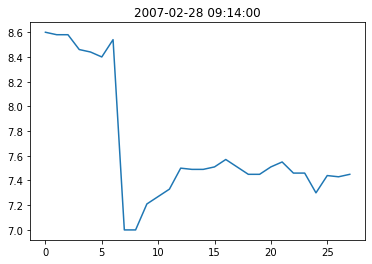

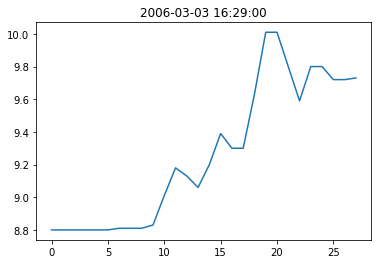

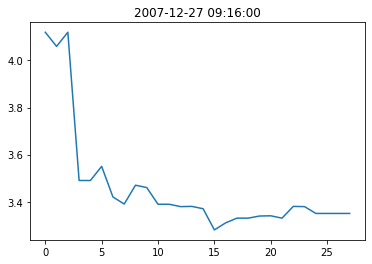

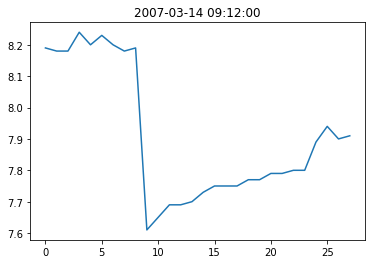

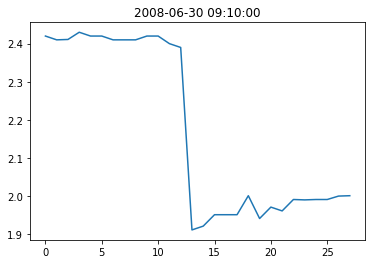

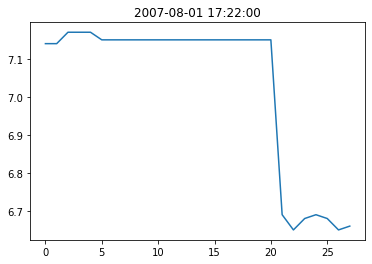

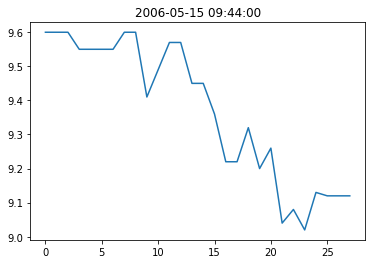

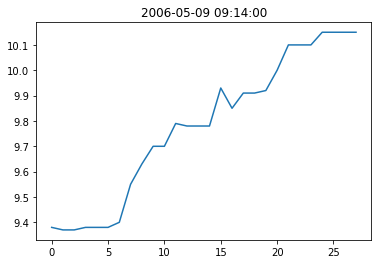

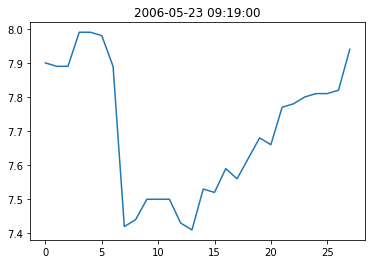

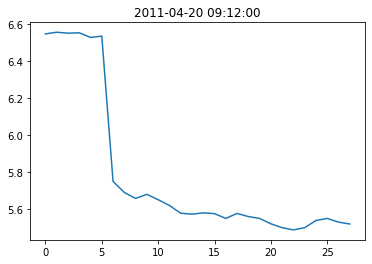

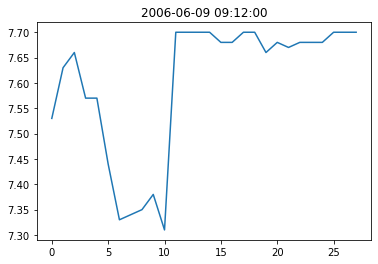

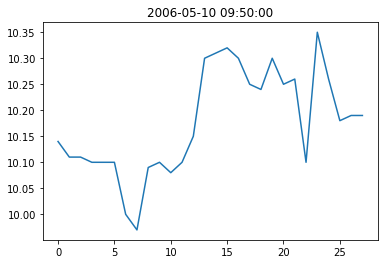

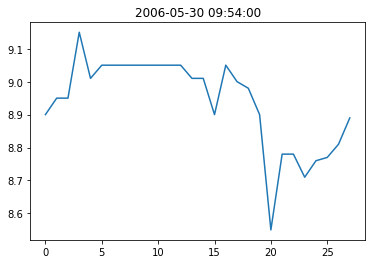

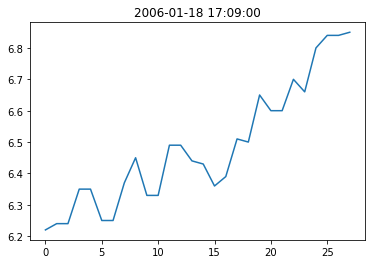

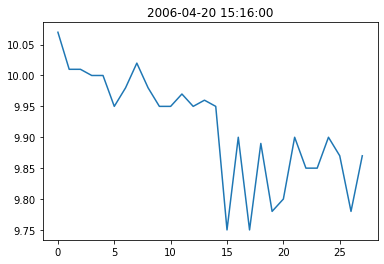

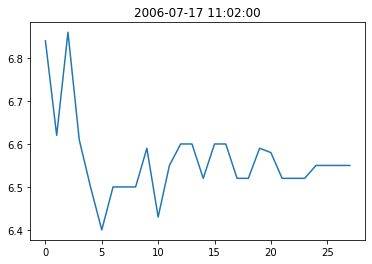

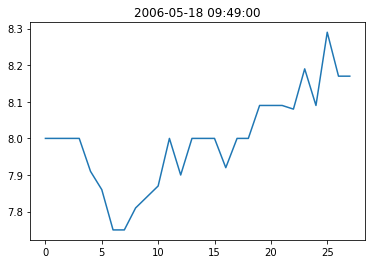

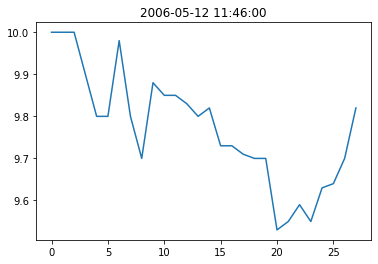

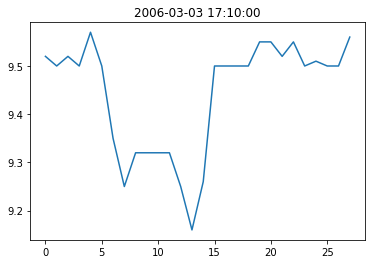

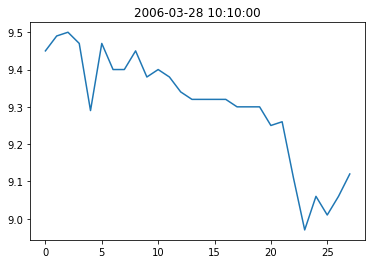

In [65]:
for ind in df_results.sort_values("final_score",ascending=False).index[0:20]:
    sub_curve(df_results,ind)